<a href="https://colab.research.google.com/github/NOBODIDI/APS360_GeoGuessr_NN/blob/main/primary_model/Peter's_Tuning_(AlexNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful Links

*   Background info: https://cs231n.github.io/transfer-learning/
*   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Finetuning: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell
cp -r "/content/drive/MyDrive/train_val_test_split" "/content/train_val_test_split"

REMEMBER TO CHANGE RUNTIME TO GPU AND THEN MOUNT GOOGLE DRIVE (ALSO ADD TRAIN_VAL_TEST_SPLIT AS A SHORTCUT TO DRIVE)

In [ ]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import shutil
import time
import copy

### Initializing Model

In [ ]:
def init_model(model_name):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    net = None
    input_size = 0

    if model_name == "resnet":
        """ WideResnet50 
        https://pytorch.org/vision/master/models/generated/torchvision.models.wide_resnet50_2.html#torchvision.models.wide_resnet50_2
        """
        net = models.wide_resnet50_2(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = False
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "resnet50":
        """ Resnet50 
        https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
        """
        net = models.resnet50(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = True
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "alexnet":
        """ Alexnet
        https://pytorch.org/vision/master/models/generated/torchvision.models.alexnet.html#torchvision.models.alexnet
        """
        net = models.alexnet(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = False
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "vgg":
        """ VGG11_bn
        https://pytorch.org/vision/master/models/generated/torchvision.models.vgg11_bn.html#torchvision.models.vgg11_bn
        """
        net = models.vgg11_bn(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = False
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        https://pytorch.org/vision/master/models/generated/torchvision.models.inception_v3.html#torchvision.models.inception_v3
        """
        net = models.inception_v3(weights='DEFAULT')
        # Freezing all the gradients of the model parameters (TRANSFER LEARNING)
        for param in net.parameters():
            param.requires_grad = False
        # Handle the auxilary net
        num_ftrs = net.AuxLogits.fc.in_features
        net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs,num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    # Choosing which parameter gradients to optimize (only at the final FC layers)
    params_to_update = []
    print("Params to learn:")
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name,len(param))

    return net, params_to_update

#### Datasets and Dataloaders (Run ONCE)

In [ ]:
# Loading in Data

# /////////// CHANGE THIS TO TRUE IF YOU WANT TO USE INCEPTION /////////
is_inception = False
# /////////////////////////////////////////////////////////
if is_inception:
    resize = 342
    input_size = 299
else:
    resize = 256
    input_size = 224

# Data augmentation and normalization for training
# Just normalization for validation, test

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# ////////////////// CHANGE THIS IF NEEDED TO POINT TO THE DATA ////////////////////////
root_path = "/content/train_val_test_split"
# // ORIGINAL 8K DATASET: "/content/drive/MyDrive/train_val_test_split"
# // NEW 80K DATASET: "/content/drive/MyDrive/GeoGuessr Train Val Test"
# ////////////////////////////////////////////////////////////////////////////////

# Fixed PyTorch random seed for reproducible result
torch.manual_seed(1000)

# Create training and validation and test datasets
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(root_path, x), 
                                                      data_transforms[x]) for x in ['train', 'val','test']}

classes = image_datasets['train'].classes
# Number of classes
num_classes = len(classes)
print("Total dataset:",len(image_datasets['train'])+len(image_datasets['val'])+len(image_datasets['test']),"\n",
      "\tTrain size:",len(image_datasets['train']),"\n\tVal size:",len(image_datasets['val']),"\n\tTest size:",len(image_datasets['test']))
print("Number of classes:",num_classes)

batch_size = 64
# Create training and validation and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
                                                   shuffle=True, num_workers=1) for x in ['train', 'val','test']}

Total dataset: 7983 
 	Train size: 5588 
	Val size: 1596 
	Test size: 799
Number of classes: 80


### Visualizing sample data (Run ONCE)

Images size: torch.Size([64, 3, 224, 224])
Labels size: torch.Size([64])


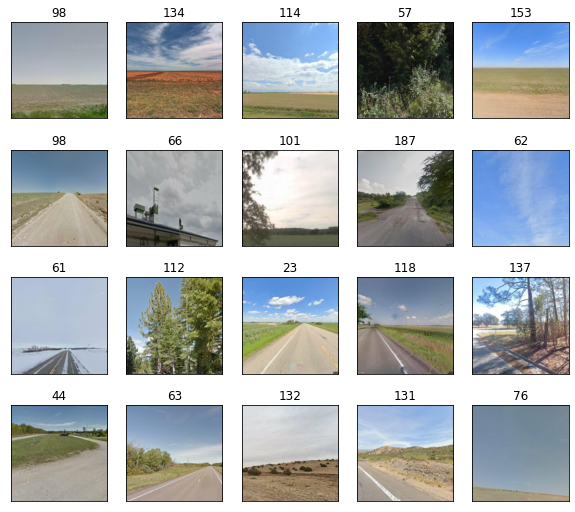

In [ ]:
# Visualize some sample data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp[0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# # obtain one batch of training images
images, labels = next(iter(dataloaders_dict['train']))
print("Images size:",images.shape)
print("Labels size:",labels.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 9))
for i in np.arange(20):
    ax = fig.add_subplot(4, 20/4, i+1, xticks=[], yticks=[])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = images[i].numpy().transpose((1,2,0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    ax.set_title(classes[labels[i]])

### Training the Model

In [ ]:
# Training code modified from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, model_name,
                datasets=image_datasets, 
                batch_size=256, 
                learning_rate=0.045, 
                halving_time=10,
                num_epochs=5, 
                aux_coef=0.4, # Inception auxiliary coefficient
                is_inception=False):
  
    since = time.time()
    # ////////////////// CHANGE THIS IF NEEDED TO POINT to your SAVE FOLDER ////////////////////////
    save_path = "/content/drive/MyDrive/AlexNet Results"
    # ////////////////////////////////////////////////////////////////////////////////
    model_path = os.path.join(save_path, "best_model_{0}_bs{1}_lr{2}_ht{3}_epochs{4}".format(model_name,
                                                                                      batch_size,
                                                                                      learning_rate,
                                                                                      halving_time,
                                                                                      num_epochs))

    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 
                                                  batch_size=batch_size, 
                                                  shuffle=True, 
                                                  num_workers=1) for x in ['train', 'val']}

    # Observe that some parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    val_loss_history = []
    val_acc_history = []
    train_loss_history = []
    train_acc_history = []
    epochs = np.arange(0,num_epochs)

    best_acc = 0.0

    for epoch in range(num_epochs):
        # start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Learning Rate schedule
        if ((epoch) % (halving_time) == 0) and (epoch != 0):
          learning_rate /= 2
          optimizer = optim.Adam(params_to_update, lr=learning_rate)
          print('////// NEW LEARNING RATE: {:.4f} //////'.format(learning_rate))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                #############################################
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                  labels = labels.cuda()
                #############################################

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for the loss by summing the final output and the auxiliary output
                    #   but in testing inception because in training it has an auxiliary output. In train
                    #   mode we calculate  only consider the final output.
                    if phase == 'train' and is_inception == True:
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + aux_coef*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # ///////// UNCOMMENT IF YOU WANT TO SEE RUNNING LOSS ///////////////////////////
                # print('{} Running Loss: {:.4f} Running Acc: {:.4f}'.format(phase, running_loss, running_corrects))

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), model_path)
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        time_elapsed = time.time() - since
        print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
        print('-' * 10)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    plt.title("Training vs Validation Loss Curve")
    plt.plot(epochs, train_loss_history, label="Train")
    plt.plot(epochs, val_loss_history, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training vs Validation Accuracy Curve")
    plt.plot(epochs, train_acc_history, label="Train")
    plt.plot(epochs, val_acc_history, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # load best model weights
    state = torch.load(model_path)
    model.load_state_dict(state)
    return model

## Training Model

In [ ]:
# /////////////////////// HERE IS WHERE YOU CHANGE THE MODEL NAME ///////////////////////
model_name = 'alexnet' # change from 'resnet' to model of choice
model, params_to_update = init_model(model_name) 
# //////////////////////////////////////////////////////////////////////////////////////
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

trained_model = train_model(model, model_name, 
                            datasets=image_datasets, 
                            batch_size=256, 
                            learning_rate=0.0005, 
                            halving_time=20, 
                            num_epochs=75)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Params to learn:
	 classifier.6.weight 80
	 classifier.6.bias 80
CUDA is available!  Training on GPU ...
Epoch 0/74
----------
train Loss: 4.2393 Acc: 0.0327


## Testing Model


In [ ]:
def test_model(model, 
               datasets=image_datasets, 
               batch_size=256 ):
  
    since = time.time()
    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 
                                                  batch_size=batch_size, 
                                                  shuffle=True, 
                                                  num_workers=1) for x in ['test']}

    model.eval()   # Set model to evaluate mode
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['test']:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################

        # Get model outputs and calculate loss
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    test_acc = float(running_corrects) / len(dataloaders['test'].dataset)

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(test_acc))

    return

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  trained_model = trained_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


test_model(trained_model, datasets=image_datasets, batch_size=256)

NameError: ignored